In [58]:
from time import localtime, strftime
strftime("%Y-%m-%d %H:%M:%S", localtime())

'2017-03-08 00:26:09'

# Importing the necessary packages

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Reading the train dataset, test dataset and the target for the train dataset from the train labels file

In [60]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_target = pd.read_csv("train labels.csv")

In [61]:
print("head of train")
train.head(1)

head of train


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [62]:
print("head of test")
test.head(1)

head of test


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other


In [63]:
print("head of train labels")
train_target.head(1)

head of train labels


,id,status_group
0,69572,functional


In [64]:
train = train.drop(["id"], axis = 1) #Dropping the id from the train dataset as it will not help in any way in predicting the target
test_ids = test['id'] #Keeping the test ids in a separate file for final prediction
test = test.drop(["id"], axis = 1) #Again dropping the ids from the test dataset as they are not going to help in final prediction
train_target = train_target.drop(["id"], axis = 1) #Similarly dropping the ids from the train labels dataset

In [65]:
print ("The shape of the train dataset is " + str(train.shape))
print ("The shape of the test dataset is " + str(test.shape))

The shape of the train dataset is (59400, 39)
The shape of the test dataset is (14850, 39)


So there are 39 features that are in some way contributing or not contributing to the classification of the pumps. We will have to design a model based on the features available so that our accuracy of the status of the pumps is highest

# Lets check out the nature of the train dataset/

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-null object


Lets examine one feature at a time. We will look for opportunities for feature engineering. Feature engineering is one of the best methods by which we can increase the accuracy of our model. But first of all, lets check how many classes of target variable is present

In [67]:
print ("The number of classes in target variable are ")
train_target['status_group'].value_counts()

The number of classes in target variable are 


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

So it is a multiclass classfication problem. The classes are functional, non functional and functional needs repair

In [68]:
proportion = (train_target['status_group'].value_counts()/train_target['status_group'].value_counts().sum())
proportion

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

# Joining the train and test dataset so as to prevent doing the same operation on train and test dataset twice

In [69]:
df = train.append(test, ignore_index = True)

In [70]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# For the continuous variables
1. For variable amount_tsh, most of the values are 0.  
2. The latitude values are between -5.7 to -2. Similarly the longitude values are between 34.07 and 40.34.  
3. No description is available for num_private variable so we will have to drop this variable.  
4. The region codes and district codes are already given . They are given as continuous variables but they are acually categorial variables. We will change them into categorical variables  
5. Population and construction year might have a significant impact on the outcome. However these two variables have a lot of zeros which is not logical. It means that all these zeros are missing values and we will have treat these zeros. We will fill these zeros of population with median value and the zeros of construction year with the most frequent value

In [71]:
df = df.drop(['num_private'], axis = 1)

# Total Static Head

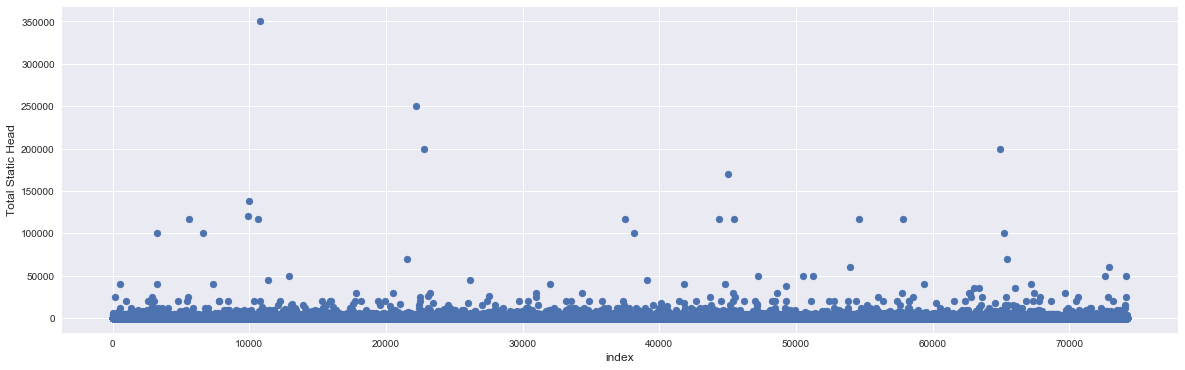

In [72]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.amount_tsh.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Total Static Head', fontsize=12)
plt.show()

There are some outliers in the total static head. We will merge those outliers

In [73]:
ulimit_df = np.percentile(df.amount_tsh.values, 99.9)
df.amount_tsh.ix[df.amount_tsh.values>ulimit_df] = ulimit_df

# GPS Height

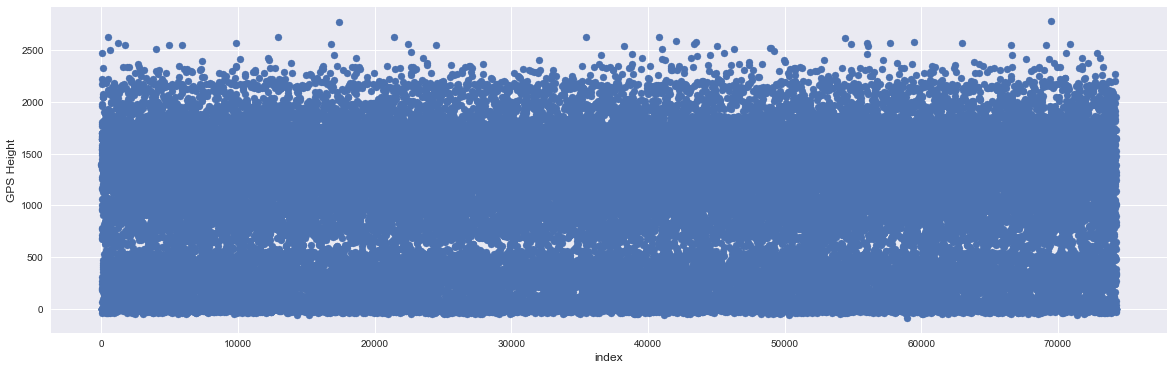

In [74]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.gps_height.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('GPS Height', fontsize=12)
plt.show()

The GPS height is evenly distributed. We will not touch them

# Longitude

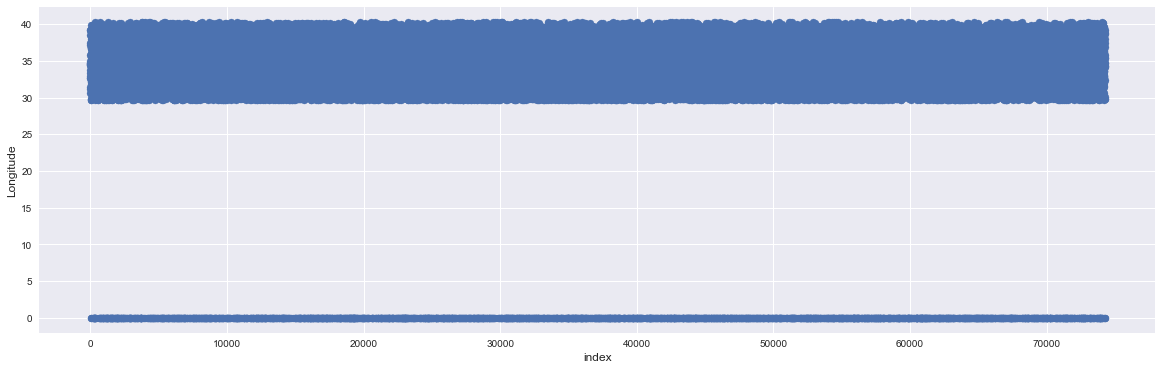

In [75]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.longitude.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.show()

# Latitude

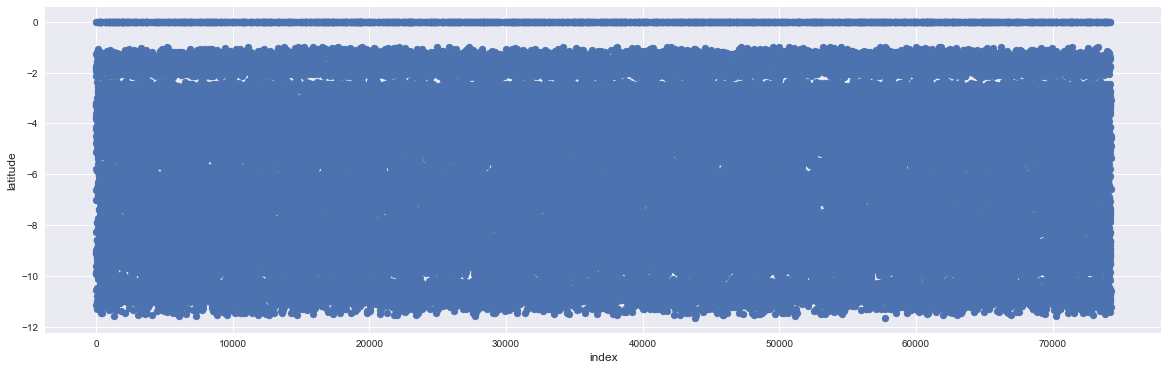

In [76]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.latitude.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('latitude', fontsize=12)
plt.show()

One thing to note here is that those there are lots of missing values for longitude and latitude disguised in the form of zeros. We will drop longitude and latitudes. We already have region codes and district codes. So we will use those variables instead of latitudes and longitudes

In [77]:
df = df.drop(['longitude','latitude'], axis = 1)

Treating the missing values of population and construction year

In [78]:
(df['population']==0).value_counts()

False    47416
True     26834
Name: population, dtype: int64

In [79]:
(df['construction_year']==0).value_counts()

False    48281
True     25969
Name: construction_year, dtype: int64

We will fill the missing values of population with the median and the construction year with the most frequent value

In [80]:
df['population'] = df['population'].fillna(df['population'].median())
if df['construction_year'].value_counts().index[0]==0:
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].value_counts().index[1])
else:
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].value_counts().index[0])

In [81]:
df['region_code'] = df['region_code'].astype(object)
df['district_code'] = df['district_code'].astype(object)

In [82]:
df.describe()

,amount_tsh,gps_height,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000
mean,276.167186,665.667313,180.750828,1298.463650
std,1255.914955,692.761033,471.086120,952.349375
min,0.000000,-90.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,364.000000,25.000000,1986.000000
75%,20.000000,1317.000000,215.000000,2004.000000
max,20000.000000,2777.000000,30500.000000,2013.000000


In [83]:
cont = []
for col in df.columns.values:
    if df[col].dtype != 'object':
        cont.append(col)
df_cont = df[cont]
df_cat = df.drop(cont, axis=1)
print ("The categorical variables in the dataset are")
df_cat.head(1)

The categorical variables in the dataset are


,date_recorded,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,...,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,...,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [84]:
pd.set_option('display.max_columns', df.shape[1])
df_cat.describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,74250,74250,70095,74250,69404,38992,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,27,20,125,2098,2,1,12,2868,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,11,1,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,6608,15299,3128,386,63749,74250,45917,858,48606,33263,33263,33263,50624,65538,31712,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


In [85]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull())>0:
        value = np.sum(df_cat[col].isnull())
        print(col,value)

funder 4504
installer 4532
subvillage 470
public_meeting 4155
scheme_management 4846
scheme_name 35258
permit 3793


# For the categorical variables
1. We will modify the date recorded variable and take only the year
2. We will drop the funder variable as I am not able to see how funder can affect the status of the pump.
3. Installer might be a very important variable. We will impute the missing the missing values with the most frequent values
4. Water point name wpt_name variable is not important as the name of the waterpoint will not have any impact on the status of the pump
5. We are going to drop the variable region as we already have region_code
6. We will drop the public meeting variable
7. From the description of the dataset, the scheme name and the scheme management variables seem to be similar. We will keep the scheme management variable and drop the scheme name variable as it has a lot of missing values
8. We will fill the NA values of permit variable with the most frequent value.
9. Out of extraction_type, extraction_type_group, extraction_type-class, we are going to keep only the extraction_type variable. These three variables are similar. The number of unique values in this feature is the highest and that is why we are going to keep this variable.
10. Out of payment and payment_type variables we will keep only one variable
11. We will drop the water_quality, quality_group. Quality will not have an impact on 
12. Out of quantity and quantity_type variables we keep only one variable
13. Out of source, source_type, source_class we will keep the source variable as these three variables are quite similar and the source variable has the most variations
14. Out of waterpoint_type and waterpoint_type_group we will keep the waterpoint_type variable as these two variables are quite similar and the waterpoint_type variable has the most variations

In [86]:
df["entered_year"] = pd.to_datetime(df["date_recorded"]).dt.year
df = df.drop(['date_recorded','funder','wpt_name','region','scheme_name','public_meeting','extraction_type_group',
              'extraction_type_class','payment_type','water_quality','quality_group','quantity_group',
              'source_type','source_class','waterpoint_type_group'], axis = 1)
df['subvillage'] = df['subvillage'].fillna(df['subvillage'].value_counts().index[0])
df['installer'] = df['installer'].fillna(df['installer'].value_counts().index[0])
df['scheme_management'] = df['scheme_management'].fillna(df['scheme_management'].value_counts().index[0])
df['permit'] = df['permit'].fillna(df['permit'].value_counts().index[0])

The variables installer, subvillage, region_codes, district_codes, ward, lga has lots of classes. So we will have to decrease the classes. We will divide the  dataframe again into train and test.

In [87]:
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

We are going to print the number of unique values of those variables which has lots of classes in the train and test  datasset

In [88]:
train_installers_list = train.installer.unique()
test_installers_list = test.installer.unique()
print("Number of installers in Train dataset: {0}".format(len(train_installers_list)))
print("Number of installers in Test dataset: {0}".format(len(test_installers_list)))

train_subvillages_list = train.subvillage.unique()
test_subvillages_list = test.subvillage.unique()
print("Number of subvillages in Train dataset: {0}".format(len(train_subvillages_list)))
print("Number of subvillages in Test dataset: {0}".format(len(test_subvillages_list)))

train_lga_list = train.lga.unique()
test_lga_list = test.lga.unique()
print("Number of LGAs in Train dataset: {0}".format(len(train_lga_list)))
print("Number of LGAs in Test dataset: {0}".format(len(test_lga_list)))

train_ward_list = train.ward.unique()
test_ward_list = test.ward.unique()
print("Number of wards in Train dataset: {0}".format(len(train_ward_list)))
print("Number of wards in Test dataset: {0}".format(len(test_ward_list)))

Number of installers in Train dataset: 2145
Number of installers in Test dataset: 1091
Number of subvillages in Train dataset: 19287
Number of subvillages in Test dataset: 8443
Number of LGAs in Train dataset: 125
Number of LGAs in Test dataset: 125
Number of wards in Train dataset: 2092
Number of wards in Test dataset: 1959


We are going to see how many classes of these variables are present in train and absent in test and vice versa. For ward and lga is not that high 

In [89]:
installers_not_in_test = set(train_installers_list) - set(test_installers_list)
installers_not_in_train = set(test_installers_list) - set(train_installers_list)

print("{} installers are featured in train dataset but not in test dataset".format(len(installers_not_in_test)))
print("{} installers are featured in test dataset but not in train dataset".format(len(installers_not_in_train)))

subvillages_not_in_test = set(train_subvillages_list) - set(test_subvillages_list)
subvillages_not_in_train = set(test_subvillages_list) - set(train_subvillages_list)

print("{} subvillages are featured in train dataset but not in test dataset".format(len(subvillages_not_in_test)))
print("{} subvillages are featured in test dataset but not in train dataset".format(len(subvillages_not_in_train)))

1319 installers are featured in train dataset but not in test dataset
265 installers are featured in test dataset but not in train dataset
12982 subvillages are featured in train dataset but not in test dataset
2138 subvillages are featured in test dataset but not in train dataset


We will create two dataframes. Same thing will be done for the other variables also which has lots of classes

In [90]:
train_installer_target = pd.concat([train['installer'],train_target], axis=1)
target_dummies = pd.get_dummies(train_installer_target['status_group'])
train_installer_target = train_installer_target.drop(['status_group'], axis = 1)
train_installer_target = pd.concat([train_installer_target,target_dummies], axis=1)
train_installer_target.head(2)

,installer,functional,functional needs repair,non functional
0,Roman,1,0,0
1,GRUMETI,1,0,0


In [91]:
train_subvillages_target = pd.concat([train['subvillage'],train_target], axis=1)
target_dummies = pd.get_dummies(train_subvillages_target['status_group'])
train_subvillages_target = train_subvillages_target.drop(['status_group'], axis = 1)
train_subvillages_target = pd.concat([train_subvillages_target,target_dummies], axis=1)
train_subvillages_target.head(2)

,subvillage,functional,functional needs repair,non functional
0,Mnyusi B,1,0,0
1,Nyamara,1,0,0


In [92]:
train_lga_target = pd.concat([train['lga'],train_target], axis=1)
target_dummies = pd.get_dummies(train_lga_target['status_group'])
train_lga_target = train_lga_target.drop(['status_group'], axis = 1)
train_lga_target = pd.concat([train_lga_target,target_dummies], axis=1)
train_lga_target.head(2)

,lga,functional,functional needs repair,non functional
0,Ludewa,1,0,0
1,Serengeti,1,0,0


In [93]:
train_ward_target = pd.concat([train['ward'],train_target], axis=1)
target_dummies = pd.get_dummies(train_ward_target['status_group'])
train_ward_target = train_ward_target.drop(['status_group'], axis = 1)
train_ward_target = pd.concat([train_ward_target,target_dummies], axis=1)
train_ward_target.head(2)

,ward,functional,functional needs repair,non functional
0,Mundindi,1,0,0
1,Natta,1,0,0


We are going to group the installers and get the proportion for each status of target for each individual installer. Samr thing will be done for the other variables also

In [94]:
train_installer_target_prop = pd.concat([train_installer_target.groupby('installer').mean(),train_installer_target.groupby('installer').count()], axis = 1).iloc[:,:-2]
train_installer_target_prop.columns = ['functional','functional needs repair','non functional','count']
train_installer_target_prop.sort_values(by='count',ascending=False).head()

,functional,functional needs repair,non functional,count
installer,,,,
DWE,0.542955,0.097925,0.359120,21057
Government,0.293151,0.140274,0.566575,1825
RWE,0.252073,0.113599,0.634328,1206
Commu,0.683019,0.030189,0.286792,1060
DANIDA,0.516190,0.079048,0.404762,1050


In [95]:
train_subvillages_target_prop = pd.concat([train_subvillages_target.groupby('subvillage').mean(),train_subvillages_target.groupby('subvillage').count()], axis = 1).iloc[:,:-2]
train_subvillages_target_prop.columns = ['functional','functional needs repair','non functional','count']
train_subvillages_target_prop.sort_values(by='count',ascending=False).head()

,functional,functional needs repair,non functional,count
subvillage,,,,
Shuleni,0.497149,0.051311,0.451539,877
Madukani,0.488189,0.084646,0.427165,508
Majengo,0.466135,0.071713,0.462151,502
Kati,0.576408,0.115282,0.308311,373
Mtakuja,0.541985,0.053435,0.404580,262


In [96]:
train_lga_target_prop = pd.concat([train_lga_target.groupby('lga').mean(),train_lga_target.groupby('lga').count()], axis = 1).iloc[:,:-2]
train_lga_target_prop.columns = ['functional','functional needs repair','non functional','count']
train_lga_target_prop.sort_values(by='count',ascending=False).head()

,functional,functional needs repair,non functional,count
lga,,,,
Njombe,0.801838,0.037555,0.160607,2503
Arusha Rural,0.698882,0.038339,0.262780,1252
Moshi Rural,0.585931,0.095124,0.318945,1251
Bariadi,0.492778,0.347494,0.159728,1177
Rungwe,0.611212,0.145570,0.243219,1106


In [97]:
train_ward_target_prop = pd.concat([train_ward_target.groupby('ward').mean(),train_ward_target.groupby('ward').count()], axis = 1).iloc[:,:-2]
train_ward_target_prop.columns = ['functional','functional needs repair','non functional','count']
train_ward_target_prop.sort_values(by='count',ascending=False).head()

,functional,functional needs repair,non functional,count
ward,,,,
Igosi,0.941368,0.000000,0.058632,307
Imalinyi,0.952381,0.011905,0.035714,252
Siha Kati,0.982759,0.008621,0.008621,232
Mdandu,0.874459,0.056277,0.069264,231
Nduruma,0.631336,0.073733,0.294931,217


1. So the idea is that for a certain installer, the proportion for functional is greater than 0.54 (the proportion of functional in the total target variable) then the installer installs functional pump. If the proportion for non functional is greater than 0.38, then the installer installs non functional pump and if the proportion for functional needs repair category is greater than 0.07, then the installer installs functional pumps which need repair.   
2. The ordering has been done in such a way that since the proportion category for functional needs repair is the least in target variable that is why our main target would be capture the pumps which need repair. So if for a certain installer, the proportion for functional, functional needs repair, non functional is 0.54XX, 0.38XX, 0.07XX, then the category for that intaller would be functional needs repair, since that category comes last in the below code
3. The same thing will be done for those other variables also

In [98]:
train_installer_target_prop['category'] = np.zeros((train_installer_target_prop.shape[0],1))
train_installer_target_prop['category'].loc[train_installer_target_prop['functional'] > 0.54] = 'functional'
train_installer_target_prop['category'].loc[train_installer_target_prop['non functional'] > 0.38] = 'non functional'
train_installer_target_prop['category'].loc[train_installer_target_prop['functional needs repair'] > 0.07] = 'functional needs repair'

train_subvillages_target_prop['category'] = np.zeros((train_subvillages_target_prop.shape[0],1))
train_subvillages_target_prop['category'].loc[train_subvillages_target_prop['functional'] > 0.54] = 'functional'
train_subvillages_target_prop['category'].loc[train_subvillages_target_prop['non functional'] > 0.38] = 'non functional'
train_subvillages_target_prop['category'].loc[train_subvillages_target_prop['functional needs repair'] > 0.07] = 'functional needs repair'

train_lga_target_prop['category'] = np.zeros((train_lga_target_prop.shape[0],1))
train_lga_target_prop['category'].loc[train_lga_target_prop['functional'] > 0.54] = 'functional'
train_lga_target_prop['category'].loc[train_lga_target_prop['non functional'] > 0.38] = 'non functional'
train_lga_target_prop['category'].loc[train_lga_target_prop['functional needs repair'] > 0.07] = 'functional needs repair'

train_ward_target_prop['category'] = np.zeros((train_ward_target_prop.shape[0],1))
train_ward_target_prop['category'].loc[train_ward_target_prop['functional'] > 0.54] = 'functional'
train_ward_target_prop['category'].loc[train_ward_target_prop['non functional'] > 0.38] = 'non functional'
train_ward_target_prop['category'].loc[train_ward_target_prop['functional needs repair'] > 0.07] = 'functional needs repair'

Creating additional variables installer category  variable which will store whether that installer is contributing towards which status of pump

In [99]:
train['installer_category'] = train.installer.map(train_installer_target_prop.category)
test['installer_category'] = test.installer.map(train_installer_target_prop.category)
test['installer_category'] = test['installer_category'].fillna(test['installer_category'].value_counts().index[0])

train['subvillage_category'] = train.installer.map(train_subvillages_target_prop.category)
test['subvillage_category'] = test.installer.map(train_subvillages_target_prop.category)
test['subvillage_category'] = test['subvillage_category'].fillna(test['subvillage_category'].value_counts().index[0])

train['lga_category'] = train.lga.map(train_lga_target_prop.category)
test['lga_category'] = test.lga.map(train_lga_target_prop.category)
test['lga_category'] = test['lga_category'].fillna(test['lga_category'].value_counts().index[0])

train['ward_category'] = train.ward.map(train_ward_target_prop.category)
test['ward_category'] = test.ward.map(train_ward_target_prop.category)
test['ward_category'] = test['ward_category'].fillna(test['ward_category'].value_counts().index[0])

Dropping the installer since we have done feature engineering on it. Same thing will be done for those other variables

In [100]:
df = train.append(test, ignore_index = True)
df = df.drop(['installer','subvillage','lga','ward'], axis = 1)

In [101]:
pd.set_option('display.max_columns', df.shape[1])
df.describe(include = ['O'])

,basin,region_code,district_code,recorded_by,scheme_management,extraction_type,management,management_group,payment,quantity,source,waterpoint_type,installer_category,subvillage_category,lga_category,ward_category
count,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,17958,74250,74250
unique,9,27,20,1,12,18,12,5,7,5,10,7,3,3,3,3
top,Lake Victoria,11,1,GeoData Consultants Ltd,VWC,gravity,vwc,user-group,never pay,enough,spring,communal standpipe,functional needs repair,functional,functional needs repair,functional
freq,12871,6608,15299,74250,50763,33263,50624,65538,31712,41522,21216,35628,41448,16528,29215,26236


recorded_by variable only has one value. So we are going to drop this variable

In [102]:
df = df.drop(['recorded_by'], axis =1)

In [103]:
df['operation_year'] = df['entered_year'] - df['construction_year']

In [104]:
df = df.drop(['entered_year','construction_year'], axis = 1)

In [105]:
df_dummies = pd.get_dummies(df)

In [106]:
df_dummies.shape

(74250, 149)

In [107]:
train = df_dummies.iloc[:59400,:]
test = df_dummies.iloc[59400:,:]

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [54]:
classifiers = [LogisticRegression(solver='lbfgs', multi_class='multinomial', C = 3000, tol = 0.0001),
               KNeighborsClassifier(n_neighbors = 15),
               GaussianNB(),
               RandomForestClassifier(n_estimators=500, random_state = 8)]

In [55]:
for clf in classifiers:
    name = clf.__class__.__name__
    Score = cross_val_score(clf, train, np.ravel(train_target), scoring = 'accuracy',cv=5).mean()
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print("Score: {}".format(Score))
    
print("="*30)

LogisticRegression
****Results****
Score: 0.7287375146245771
KNeighborsClassifier
****Results****
Score: 0.6928617405028368
GaussianNB
****Results****
Score: 0.5654211693541658
RandomForestClassifier
****Results****
Score: 0.7965487687907384


In [127]:
cat_train = df.iloc[:59400,:]

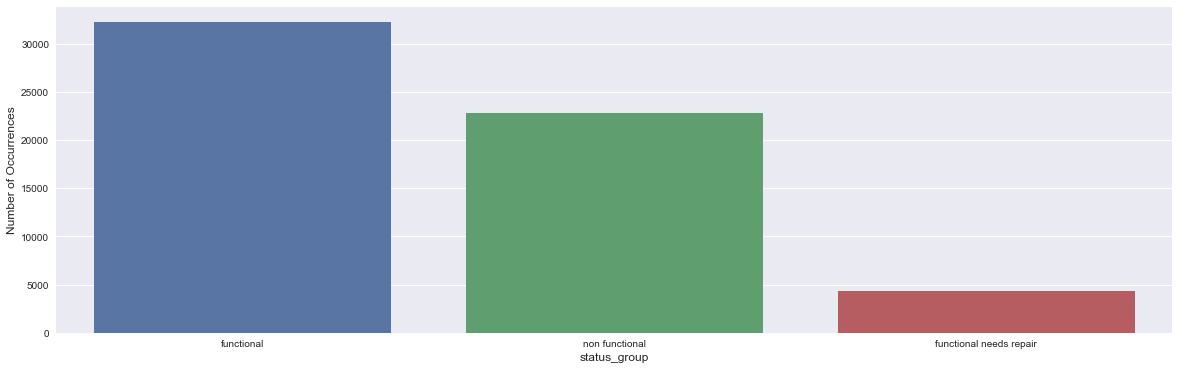

In [141]:
plt.figure(figsize=(20,6))
sns.countplot(train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('status_group', fontsize=12)
plt.show()

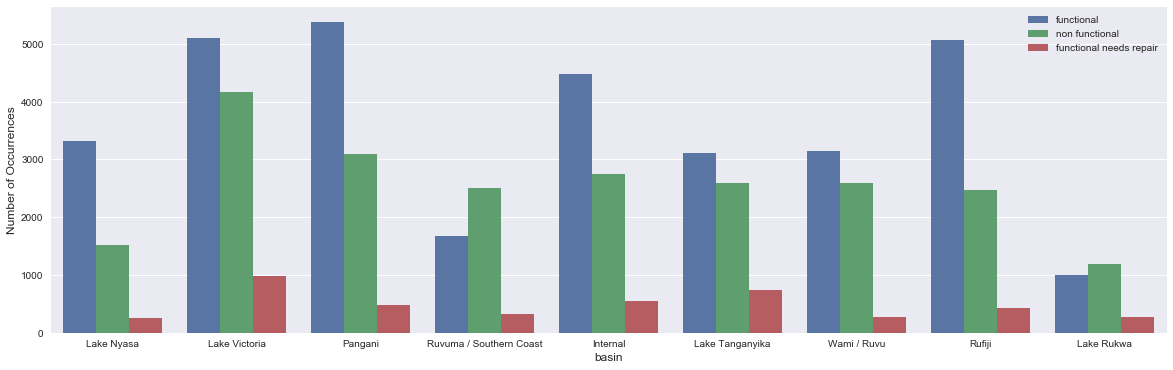

In [142]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['basin'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('basin', fontsize=12)
plt.show()

In [64]:
model = RandomForestClassifier(n_estimators=1000,random_state = 8)
model.fit(train,np.ravel(train_target))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=8,
            verbose=0, warm_start=False)

In [65]:
test_predictions = model.predict(test)

In [66]:
submission = pd.DataFrame(test_predictions, columns=['status_group'])
submission.insert(0, 'id', test_ids)
submission.reset_index()
submission.to_csv('submission.csv', index = False)

In [67]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [68]:
submission['status_group'].value_counts()

functional                 8759
non functional             5452
functional needs repair     639
Name: status_group, dtype: int64

In [63]:
strftime("%Y-%m-%d %H:%M:%S", localtime())

'2017-03-04 13:02:30'